# Applied Data Science Capstone Project
## Battle Of Neighborhood

In this Poject we will try to find out sevral location having potential Indian restaurant Market in Toronto, Canada.
We will try to find out the following.

* <b>List all major parts of Toronto that already has Indian restaurant.</b>
* <b>Find the best location in Toronto for Indian Cuisine.</b>
* <b>Find areas in Toronto have Potential Indian restaurant Market.</b>
* <b>Find areas in Toronto lack Indian restaurant.</b>
* <b>Which is the best place in Toronto to stay if you prefer Indian Cuisine.</b>

##### Importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


##### Scrapping Data from the data source of Canada with postal codes,Bourough and Neighborhood.

In [2]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r=requests.get(url) #requesting response from the page.
soup=BeautifulSoup(r.content,'html.parser')

In [3]:
column=[]
for th in soup.find_all('th'):
    column.append(th.text[:-1])
column=column[:-1]
data=[]
for tr in soup.find_all('tr'):
        rows=[i.text[:-1] for i in tr.find_all('td')]
        data.append(rows)
data=data[1:-4]
df=pd.DataFrame(data,columns=column)
df.head(10)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [4]:
df.describe()

,Postal Code,Borough,Neighbourhood
count,180,180,180
unique,180,11,100
top,M7V,Not assigned,Not assigned
freq,1,77,77


In [5]:
df.shape

(180, 3)

##### Cleaning the Data

In [6]:
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
df.head(10)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
df=df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
df.describe()

,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M3K,North York,Downsview
freq,1,24,4


In [9]:
df.shape

(103, 3)

##### Retreiving the Lattitude and Longitude of several locations from Geospatial.csv.

In [10]:
geodata=pd.read_csv("http://cocl.us/Geospatial_data")
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<b>Merge the lattitude and longitude with corresponding Postal Code.</b>

In [11]:
df_pos = pd.merge(df, geodata, on=['Postal Code'], how='inner')
df_pos.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<b>Starting with Toronto city.</b>

In [12]:
df_torneigh=df_pos[df["Borough"].str.contains('Toronto')].reset_index(drop=True)
df_torneigh.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


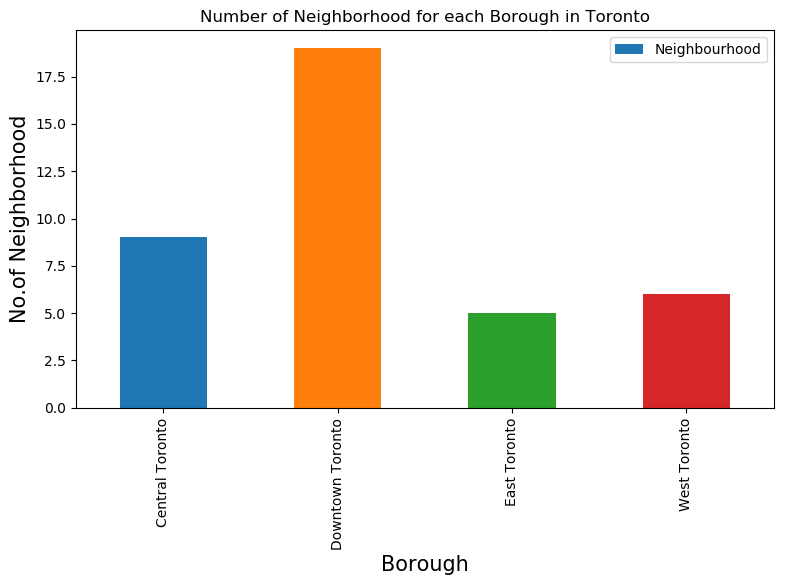

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
df_torneigh.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

<b>Now we can see that Downtown Toronto has the highest number of neighbourhoods.</b>

now using folium lets visualize Toront map

In [14]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of City of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of City of Toronto are 43.6534817, -79.3839347.


In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_pos['Latitude'], df_pos['Longitude'], df_pos['Borough'], df_pos['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

##### Now Let's find Indian restaurant for each Neighborhood around 5 km.

In [90]:
CLIENT_ID = 'Not shareable.' # your Foursquare ID
CLIENT_SECRET = 'Not shareable.' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Not shareable.
CLIENT_SECRET:Not shareable.


In [17]:
df_torneigh.loc[0, 'Neighbourhood']

'The Beaches'

In [18]:
neighborhood_latitude = df_torneigh.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_torneigh.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_torneigh.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


In [19]:
# type your answer here
LIMIT=100
radius=5000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url
print("Sorry But not printing url as it contains data that is not shareable")

Sorry But not printing url as it contains data that is not shareable


In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1987099eba8045b9f5b8be'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 222,
  'suggestedBounds': {'ne': {'lat': 43.72135744500004,
    'lng': -79.23092834490522},
   'sw': {'lat': 43.63135735499995, 'lng': -79.35513405509478}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5286b7dd498e8b747c1dfe71',
       'name': 'The Beech Tree',
       'location': {'address': '924 Kingston Rd.',
        'lat': 43.680493,
        'lng': -79.288846,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.680493,
          'lng': -79.288846}],

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Finding the Venues around the Neighbourhood.

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng,id
0,The Beech Tree,Gastropub,43.680493,-79.288846,5286b7dd498e8b747c1dfe71
1,The Fox Theatre,Indie Movie Theater,43.672801,-79.287272,4ad4c062f964a520c4f720e3
2,Ed's Real Scoop,Ice Cream Shop,43.672630,-79.287993,4b37c839f964a5200e4625e3
3,Tori's Bakeshop,Vegetarian / Vegan Restaurant,43.672114,-79.290331,4f5a855be4b0a4baa1ae0063
4,Kew Gardens,Park,43.669038,-79.298538,4bae1ed7f964a520ba863be3
5,Beaches Bake Shop,Bakery,43.680363,-79.289692,4c0e40c0c700c9b6e185a3dd
6,Glen Manor Ravine,Trail,43.676821,-79.293942,4bd461bc77b29c74a07d9282
7,Bagels On Fire,Bagel Shop,43.672864,-79.286784,51e2a41f498ec07b5f39be58
8,I'm On The Beach,Beach,43.670364,-79.284696,4c4a6282f7cc1b8d7da94e3e
9,Kew-Balmy Beach,Beach,43.667372,-79.295312,4bf9a4ac4a67c928773a27cf


In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            v['venue']['id'],
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue id','Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
Toronto_venues = getNearbyVenues(names=df_torneigh['Neighbourhood'],
                                   latitudes=df_torneigh['Latitude'],
                                   longitudes=df_torneigh['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

### Finding the Venues which categorizes as Indian Restaurant. 

In [47]:
toronto_c=Toronto_venues.copy()

In [48]:
toronto_c.drop(Toronto_venues[Toronto_venues['Venue Category']!='Indian Restaurant'].index,inplace=True)

In [49]:
print(toronto_c.shape)
toronto_c=toronto_c.reset_index(drop=True)
toronto_c.head(1000)

(33, 8)


,Venue id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4ae0c7a8f964a520638221e3,The Beaches,43.676357,-79.293031,Udupi Palace,43.672480,-79.321275,Indian Restaurant
1,4afc9816f964a520312422e3,The Beaches,43.676357,-79.293031,Motimahal,43.672175,-79.322532,Indian Restaurant
2,4ae0c7a8f964a520638221e3,"The Danforth West, Riverdale",43.679557,-79.352188,Udupi Palace,43.672480,-79.321275,Indian Restaurant
3,4ae0c7a8f964a520638221e3,"India Bazaar, The Beaches West",43.668999,-79.315572,Udupi Palace,43.672480,-79.321275,Indian Restaurant
4,4afc9816f964a520312422e3,"India Bazaar, The Beaches West",43.668999,-79.315572,Motimahal,43.672175,-79.322532,Indian Restaurant
5,4bac30a2f964a52018ea3ae3,"India Bazaar, The Beaches West",43.668999,-79.315572,Bombay Chowpatty,43.671875,-79.324114,Indian Restaurant
6,4ae0c7a8f964a520638221e3,Studio District,43.659526,-79.340923,Udupi Palace,43.672480,-79.321275,Indian Restaurant
7,4b75c28af964a520ba222ee3,Lawrence Park,43.728020,-79.388790,Kamasutra,43.703991,-79.374597,Indian Restaurant
8,52418b0b7e48222eea81d2d2,Davisville North,43.712751,-79.390197,Pukka Restaurant,43.681055,-79.429187,Indian Restaurant
9,4c62c59ce1621b8dd0332453,Davisville North,43.712751,-79.390197,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant


In [50]:
toronto_c.groupby('Neighborhood').count()

,Venue id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",2,2,2,2,2,2,2
Christie,1,1,1,1,1,1,1
Davisville,2,2,2,2,2,2,2
Davisville North,2,2,2,2,2,2,2
"Dufferin, Dovercourt Village",2,2,2,2,2,2,2
"Forest Hill North & West, Forest Hill Road Park",2,2,2,2,2,2,2
"High Park, The Junction South",2,2,2,2,2,2,2
"India Bazaar, The Beaches West",3,3,3,3,3,3,3
Lawrence Park,1,1,1,1,1,1,1


##### Here we could find that above are the list of neighborhood area which have already established Indian restaurant.

we can see that in Toronto we have a variety of Indian Restaurants and established Indian restaurant Market.

From above we can conclude that under the range of 5 km the following areas have the maximum no. of Indian Reastaurants :

##### So we can conclude that under the range  of 5 km the above areas have a very good and established Market of Indian Restaurant.
* Davisville.
* India Bazaar, The Beaches West
* North Toronto West, Lawrence Park
* Roselawn

<b> So if some on prefer to have Indian Cuisine they should should prefer to stay in such Neighborhoods

whereas the areas like :
* Christie
* Studio District.
* Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park.
* The Annex, North Midtown, Yorkville	
* The Danforth West, Riverdale	
lacks in the no. of Indian Restaurant.

<b>The most important thing is that the Neighborhood which have an average no. of Indian restaurant have a good potential market for Indian Restaurant owners because of the following reasons.</b>
* It have less competition than the more established Market and it is not very much far from them also.
* Due to less no. of Indian Restaurant in the Neighborhood the a new restaurant gives customers opprtunities to choose.
* Get more chance to establish itself.

##### Let's now try to the best Indian Restaurant in the Neighborhood.

let gather the venue id of each venue

In [84]:
Venuesid=toronto_c['Venue id']
CLIENT_ID = 'Not Shareable.' # my Foursquare ID
CLIENT_SECRET = 'Not shareable.'

In [85]:
data=[]
for venue in Venuesid:
    venue_id=venue
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    result = requests.get(url).json()
    print(result)
    try:
        print(result['response']['venue']['name']+str(result['response']['venue']['rating']))
        row=[result['response']['venue']['name'],result['response']['venue']['rating']]
        data.append(row)
    except:
        traceback_except
        print('This venue has not been rated yet.')
new_data=pd.DataFrame(data,columns=['Restaurant','Rating'])
new_data.head()

{'meta': {'code': 200, 'requestId': '5f19954ee9e5125d4df3c928'}, 'response': {'venue': {'id': '4ae0c7a8f964a520638221e3', 'name': 'Udupi Palace', 'contact': {'phone': '4164058189', 'formattedPhone': '(416) 405-8189', 'twitter': 'udupipalaceto'}, 'location': {'address': '1460 Gerrard St E', 'crossStreet': 'Coxwell Ave', 'lat': 43.67247950462566, 'lng': -79.32127455331215, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67247950462566, 'lng': -79.32127455331215}], 'postalCode': 'M4L 2A3\u200e', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1460 Gerrard St E (Coxwell Ave)', 'Toronto ON M4L 2A3\u200e', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/udupi-palace/4ae0c7a8f964a520638221e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id':

{'meta': {'code': 200, 'requestId': '5f1994c43c3b6c57585e342f'}, 'response': {'venue': {'id': '4afc9816f964a520312422e3', 'name': 'Motimahal', 'contact': {'phone': '4164613111', 'formattedPhone': '(416) 461-3111', 'facebook': '237074869673477', 'facebookName': 'Motimahal Restaurants'}, 'location': {'address': '1422 Gerrard St East', 'crossStreet': 'Coxwell', 'lat': 43.672174809921415, 'lng': -79.32253200796698, 'labeledLatLngs': [{'label': 'display', 'lat': 43.672174809921415, 'lng': -79.32253200796698}], 'postalCode': 'M4L 1Z7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1422 Gerrard St East (Coxwell)', 'Toronto ON M4L 1Z7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/motimahal/4afc9816f964a520312422e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '5f19956792bf98175befd641'}, 'response': {'venue': {'id': '4ae0c7a8f964a520638221e3', 'name': 'Udupi Palace', 'contact': {'phone': '4164058189', 'formattedPhone': '(416) 405-8189', 'twitter': 'udupipalaceto'}, 'location': {'address': '1460 Gerrard St E', 'crossStreet': 'Coxwell Ave', 'lat': 43.67247950462566, 'lng': -79.32127455331215, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67247950462566, 'lng': -79.32127455331215}], 'postalCode': 'M4L 2A3\u200e', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1460 Gerrard St E (Coxwell Ave)', 'Toronto ON M4L 2A3\u200e', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/udupi-palace/4ae0c7a8f964a520638221e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id':

{'meta': {'code': 200, 'requestId': '5f1994c63c3b6c57585e3ab2'}, 'response': {'venue': {'id': '4ae0c7a8f964a520638221e3', 'name': 'Udupi Palace', 'contact': {'phone': '4164058189', 'formattedPhone': '(416) 405-8189', 'twitter': 'udupipalaceto'}, 'location': {'address': '1460 Gerrard St E', 'crossStreet': 'Coxwell Ave', 'lat': 43.67247950462566, 'lng': -79.32127455331215, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67247950462566, 'lng': -79.32127455331215}], 'postalCode': 'M4L 2A3\u200e', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1460 Gerrard St E (Coxwell Ave)', 'Toronto ON M4L 2A3\u200e', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/udupi-palace/4ae0c7a8f964a520638221e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id':

{'meta': {'code': 200, 'requestId': '5f1993ff375785734310b469'}, 'response': {'venue': {'id': '4afc9816f964a520312422e3', 'name': 'Motimahal', 'contact': {'phone': '4164613111', 'formattedPhone': '(416) 461-3111', 'facebook': '237074869673477', 'facebookName': 'Motimahal Restaurants'}, 'location': {'address': '1422 Gerrard St East', 'crossStreet': 'Coxwell', 'lat': 43.672174809921415, 'lng': -79.32253200796698, 'labeledLatLngs': [{'label': 'display', 'lat': 43.672174809921415, 'lng': -79.32253200796698}], 'postalCode': 'M4L 1Z7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1422 Gerrard St East (Coxwell)', 'Toronto ON M4L 1Z7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/motimahal/4afc9816f964a520312422e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '5f1993811f45d50bae951136'}, 'response': {'venue': {'id': '4bac30a2f964a52018ea3ae3', 'name': 'Bombay Chowpatty', 'contact': {'phone': '4164058080', 'formattedPhone': '(416) 405-8080'}, 'location': {'address': '1386 Gerrard St East', 'lat': 43.67187525209221, 'lng': -79.32411369274648, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67187525209221, 'lng': -79.32411369274648}], 'postalCode': 'M4L 1Z2', 'cc': 'CA', 'neighborhood': 'Little India, Toronto, ON', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1386 Gerrard St East', 'Toronto ON M4L 1Z2', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-chowpatty/4bac30a2f964a52018ea3ae3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16e94173

{'meta': {'code': 200, 'requestId': '5f1996b74e2c576b1d06e072'}, 'response': {'venue': {'id': '4ae0c7a8f964a520638221e3', 'name': 'Udupi Palace', 'contact': {'phone': '4164058189', 'formattedPhone': '(416) 405-8189', 'twitter': 'udupipalaceto'}, 'location': {'address': '1460 Gerrard St E', 'crossStreet': 'Coxwell Ave', 'lat': 43.67247950462566, 'lng': -79.32127455331215, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67247950462566, 'lng': -79.32127455331215}], 'postalCode': 'M4L 2A3\u200e', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1460 Gerrard St E (Coxwell Ave)', 'Toronto ON M4L 2A3\u200e', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/udupi-palace/4ae0c7a8f964a520638221e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id':

{'meta': {'code': 200, 'requestId': '5f19939813a607527c284f30'}, 'response': {'venue': {'id': '4b75c28af964a520ba222ee3', 'name': 'Kamasutra', 'contact': {'phone': '6472589425', 'formattedPhone': '(647) 258-9425', 'twitter': 'kamasutrarest', 'instagram': 'kamasutra_toronto'}, 'location': {'address': '1522 Bayview Avenue', 'crossStreet': 'Davisville Avenue', 'lat': 43.7039912915598, 'lng': -79.37459682773826, 'labeledLatLngs': [{'label': 'display', 'lat': 43.7039912915598, 'lng': -79.37459682773826}], 'postalCode': 'M4G 3B4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1522 Bayview Avenue (Davisville Avenue)', 'Toronto ON M4G 3B4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kamasutra/4b75c28af964a520ba222ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5f1994aac0cd9c37322ccd31'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1994bc1db3e514e931d1fa'}, 'response': {'venue': {'id': '4c62c59ce1621b8dd0332453', 'name': 'Roti Cuisine of India', 'contact': {'phone': '4169689366', 'formattedPhone': '(416) 968-9366'}, 'location': {'address': '308 Dupont St.', 'crossStreet': 'at Walmer Rd.', 'lat': 43.67461834990478, 'lng': -79.40824866273744, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67461834990478, 'lng': -79.40824866273744}], 'postalCode': 'M5R 2X8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['308 Dupont St. (at Walmer Rd.)', 'Toronto ON M5R 2X8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/roti-cuisine-of-india/4c62c59ce1621b8dd0332453', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '5f1995671b8cb275164e564c'}, 'response': {'venue': {'id': '4b75c28af964a520ba222ee3', 'name': 'Kamasutra', 'contact': {'phone': '6472589425', 'formattedPhone': '(647) 258-9425', 'twitter': 'kamasutrarest', 'instagram': 'kamasutra_toronto'}, 'location': {'address': '1522 Bayview Avenue', 'crossStreet': 'Davisville Avenue', 'lat': 43.7039912915598, 'lng': -79.37459682773826, 'labeledLatLngs': [{'label': 'display', 'lat': 43.7039912915598, 'lng': -79.37459682773826}], 'postalCode': 'M4G 3B4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1522 Bayview Avenue (Davisville Avenue)', 'Toronto ON M4G 3B4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kamasutra/4b75c28af964a520ba222ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5f1995d8756ca83e416614b0'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f19955d9eba8045b921d0cb'}, 'response': {'venue': {'id': '4c62c59ce1621b8dd0332453', 'name': 'Roti Cuisine of India', 'contact': {'phone': '4169689366', 'formattedPhone': '(416) 968-9366'}, 'location': {'address': '308 Dupont St.', 'crossStreet': 'at Walmer Rd.', 'lat': 43.67461834990478, 'lng': -79.40824866273744, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67461834990478, 'lng': -79.40824866273744}], 'postalCode': 'M5R 2X8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['308 Dupont St. (at Walmer Rd.)', 'Toronto ON M5R 2X8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/roti-cuisine-of-india/4c62c59ce1621b8dd0332453', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '5f19957492bf98175befffce'}, 'response': {'venue': {'id': '4b75c28af964a520ba222ee3', 'name': 'Kamasutra', 'contact': {'phone': '6472589425', 'formattedPhone': '(647) 258-9425', 'twitter': 'kamasutrarest', 'instagram': 'kamasutra_toronto'}, 'location': {'address': '1522 Bayview Avenue', 'crossStreet': 'Davisville Avenue', 'lat': 43.7039912915598, 'lng': -79.37459682773826, 'labeledLatLngs': [{'label': 'display', 'lat': 43.7039912915598, 'lng': -79.37459682773826}], 'postalCode': 'M4G 3B4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1522 Bayview Avenue (Davisville Avenue)', 'Toronto ON M4G 3B4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kamasutra/4b75c28af964a520ba222ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5f199679eb4b917f81f5fe3c'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1995dc756ca83e41662320'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f19950dccc8c705d0963bd0'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1994b5c0cd9c37322cefb3'}, 'response': {'venue': {'id': '4b75c28af964a520ba222ee3', 'name': 'Kamasutra', 'contact': {'phone': '6472589425', 'formattedPhone': '(647) 258-9425', 'twitter': 'kamasutrarest', 'instagram': 'kamasutra_toronto'}, 'location': {'address': '1522 Bayview Avenue', 'crossStreet': 'Davisville Avenue', 'lat': 43.7039912915598, 'lng': -79.37459682773826, 'labeledLatLngs': [{'label': 'display', 'lat': 43.7039912915598, 'lng': -79.37459682773826}], 'postalCode': 'M4G 3B4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1522 Bayview Avenue (Davisville Avenue)', 'Toronto ON M4G 3B4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kamasutra/4b75c28af964a520ba222ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5f199556d031031d4db5dd81'}, 'response': {'venue': {'id': '4c62c59ce1621b8dd0332453', 'name': 'Roti Cuisine of India', 'contact': {'phone': '4169689366', 'formattedPhone': '(416) 968-9366'}, 'location': {'address': '308 Dupont St.', 'crossStreet': 'at Walmer Rd.', 'lat': 43.67461834990478, 'lng': -79.40824866273744, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67461834990478, 'lng': -79.40824866273744}], 'postalCode': 'M5R 2X8', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['308 Dupont St. (at Walmer Rd.)', 'Toronto ON M5R 2X8', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/roti-cuisine-of-india/4c62c59ce1621b8dd0332453', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '5f1995a419523654709e8db4'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1995e1df83fc0d8c1dd916'}, 'response': {'venue': {'id': '4b75c28af964a520ba222ee3', 'name': 'Kamasutra', 'contact': {'phone': '6472589425', 'formattedPhone': '(647) 258-9425', 'twitter': 'kamasutrarest', 'instagram': 'kamasutra_toronto'}, 'location': {'address': '1522 Bayview Avenue', 'crossStreet': 'Davisville Avenue', 'lat': 43.7039912915598, 'lng': -79.37459682773826, 'labeledLatLngs': [{'label': 'display', 'lat': 43.7039912915598, 'lng': -79.37459682773826}], 'postalCode': 'M4G 3B4', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1522 Bayview Avenue (Davisville Avenue)', 'Toronto ON M4G 3B4', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/kamasutra/4b75c28af964a520ba222ee3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '5f1996c94e2c576b1d071810'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f199414375785734310f5f6'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1995a4b7cc8707f6084ce6'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1995ca979acd6d912d02fc'}, 'response': {'venue': {'id': '4b511f6ff964a520994327e3', 'name': 'Curry Twist', 'contact': {'phone': '4167695460', 'formattedPhone': '(416) 769-5460'}, 'location': {'address': '3034 Dundas St. West', 'crossStreet': 'High Park Ave.', 'lat': 43.66558068434231, 'lng': -79.47054074311107, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66558068434231, 'lng': -79.47054074311107}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3034 Dundas St. West (High Park Ave.)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/curry-twist/4b511f6ff964a520994327e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '5f1995732321bc05cd92373d'}, 'response': {'venue': {'id': '4b511f6ff964a520994327e3', 'name': 'Curry Twist', 'contact': {'phone': '4167695460', 'formattedPhone': '(416) 769-5460'}, 'location': {'address': '3034 Dundas St. West', 'crossStreet': 'High Park Ave.', 'lat': 43.66558068434231, 'lng': -79.47054074311107, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66558068434231, 'lng': -79.47054074311107}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3034 Dundas St. West (High Park Ave.)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/curry-twist/4b511f6ff964a520994327e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '5f199414cbd37754ccc7de10'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1992b20c154050637f84b8'}, 'response': {'venue': {'id': '4b511f6ff964a520994327e3', 'name': 'Curry Twist', 'contact': {'phone': '4167695460', 'formattedPhone': '(416) 769-5460'}, 'location': {'address': '3034 Dundas St. West', 'crossStreet': 'High Park Ave.', 'lat': 43.66558068434231, 'lng': -79.47054074311107, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66558068434231, 'lng': -79.47054074311107}], 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['3034 Dundas St. West (High Park Ave.)', 'Toronto ON', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/curry-twist/4b511f6ff964a520994327e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '5f1996d14e2c576b1d073296'}, 'response': {'venue': {'id': '52418b0b7e48222eea81d2d2', 'name': 'Pukka Restaurant', 'contact': {'phone': '4163421906', 'formattedPhone': '(416) 342-1906', 'twitter': 'pukkatoronto', 'facebook': '602589696448860', 'facebookUsername': 'PukkaToronto', 'facebookName': 'Pukka Toronto'}, 'location': {'address': '778 St Clair Ave West', 'crossStreet': 'St Clair West & Arlington Ave', 'lat': 43.68105502412986, 'lng': -79.4291869567722, 'labeledLatLngs': [{'label': 'display', 'lat': 43.68105502412986, 'lng': -79.4291869567722}], 'postalCode': 'M6C 1B6', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['778 St Clair Ave West (St Clair West & Arlington Ave)', 'Toronto ON M6C 1B6', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/pukka-restaurant/52418b0b7e48222eea81d2d2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'sh

{'meta': {'code': 200, 'requestId': '5f1995719eba8045b9221006'}, 'response': {'venue': {'id': '4adca78af964a520592e21e3', 'name': 'South Indian Dosa Mahal', 'contact': {'phone': '4165167701', 'formattedPhone': '(416) 516-7701', 'instagram': 'southindiandosamahal', 'facebook': '136920769654169', 'facebookUsername': 'southindiandosamahaltoronto', 'facebookName': 'South Indian Dosa Mahal'}, 'location': {'address': '9 Roncesvalles Ave', 'crossStreet': 'at Emerson Ave', 'lat': 43.639184, 'lng': -79.446109, 'labeledLatLngs': [{'label': 'display', 'lat': 43.639184, 'lng': -79.446109}], 'postalCode': 'M6R 2K2', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['9 Roncesvalles Ave (at Emerson Ave)', 'Toronto ON M6R 2K2', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/south-indian-dosa-mahal/4adca78af964a520592e21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian

{'meta': {'code': 200, 'requestId': '5f1994e53c3b6c57585e9ca8'}, 'response': {'venue': {'id': '5557eeff498ea920bf32ab39', 'name': 'Tich - Modern Indian Cuisine', 'contact': {'phone': '6473498424', 'formattedPhone': '(647) 349-8424', 'twitter': 'tichcuisine'}, 'location': {'address': '2314 lakeshore Blvd. east', 'lat': 43.617585236576126, 'lng': -79.48729759424594, 'labeledLatLngs': [{'label': 'display', 'lat': 43.617585236576126, 'lng': -79.48729759424594}], 'postalCode': 'M8V 1B5', 'cc': 'CA', 'city': 'Etobicoke', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['2314 lakeshore Blvd. east', 'Etobicoke ON M8V 1B5', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/tich--modern-indian-cuisine/5557eeff498ea920bf32ab39', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5f199399803a4b4e51e5e149'}, 'response': {'venue': {'id': '4ae0c7a8f964a520638221e3', 'name': 'Udupi Palace', 'contact': {'phone': '4164058189', 'formattedPhone': '(416) 405-8189', 'twitter': 'udupipalaceto'}, 'location': {'address': '1460 Gerrard St E', 'crossStreet': 'Coxwell Ave', 'lat': 43.67247950462566, 'lng': -79.32127455331215, 'labeledLatLngs': [{'label': 'display', 'lat': 43.67247950462566, 'lng': -79.32127455331215}], 'postalCode': 'M4L 2A3\u200e', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1460 Gerrard St E (Coxwell Ave)', 'Toronto ON M4L 2A3\u200e', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/udupi-palace/4ae0c7a8f964a520638221e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id':

{'meta': {'code': 200, 'requestId': '5f19941b5292fd2d2fd8ef86'}, 'response': {'venue': {'id': '4afc9816f964a520312422e3', 'name': 'Motimahal', 'contact': {'phone': '4164613111', 'formattedPhone': '(416) 461-3111', 'facebook': '237074869673477', 'facebookName': 'Motimahal Restaurants'}, 'location': {'address': '1422 Gerrard St East', 'crossStreet': 'Coxwell', 'lat': 43.672174809921415, 'lng': -79.32253200796698, 'labeledLatLngs': [{'label': 'display', 'lat': 43.672174809921415, 'lng': -79.32253200796698}], 'postalCode': 'M4L 1Z7', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1422 Gerrard St East (Coxwell)', 'Toronto ON M4L 1Z7', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/motimahal/4afc9816f964a520312422e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}

,Restaurant,Rating
0,Udupi Palace,8.7
1,Motimahal,8.1
2,Udupi Palace,8.7
3,Udupi Palace,8.7
4,Motimahal,8.1


In [86]:
new_data

,Restaurant,Rating
0,Udupi Palace,8.7
1,Motimahal,8.1
2,Udupi Palace,8.7
3,Udupi Palace,8.7
4,Motimahal,8.1
5,Bombay Chowpatty,7.5
6,Udupi Palace,8.7
7,Kamasutra,8.0
8,Pukka Restaurant,9.2
9,Roti Cuisine of India,8.5


No handles with labels found to put in legend.


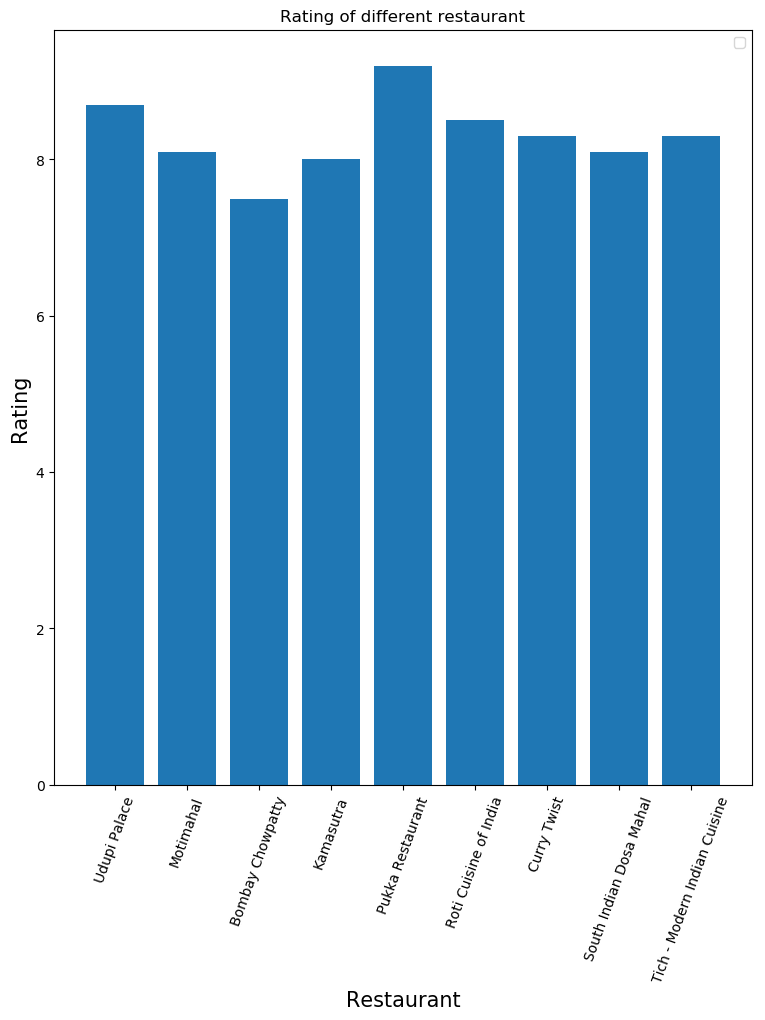

In [89]:
x=list(new_data['Restaurant'])
y=list(new_data['Rating'])
plt.figure(figsize=(9,10), dpi = 100)
# title
plt.title('Rating of different restaurant')
#On x-axis
plt.xlabel('Restaurant', fontsize = 15)
#On y-axis
plt.ylabel('Rating', fontsize=15)
plt.bar(x,y)
plt.tick_params(axis='x', rotation=70)
#legend
plt.legend()
#displays the plot
plt.show()

Here from the above plot we can see that <b>Pukka Restaurant</b> has the highest Customer rating in the Neighbourhood

##### so we could conclude that if someone prefers to have Indian Cuisine then the best place is Pukka Restaurant in the Neighbourhood.

If someone Loves Indian cuisine they could stay around these areas

## Conclusion :

from the above analysis we are now able to answer the question which we were trying to find out.

* we have listed the Neighbourhood which have an established Indian Restaurant Market.
* we have found the best locations in Toronto to have Indian Cuisine, which is <b>Pukka Restaurant</b>. since there are mulitple branches of Pukka Restaurant one could try any of the following:
     * Pukka Restaurant ,Davisville North	.
     * Pukka Restaurant ,North Toronto West, Lawrence Park.
     * Pukka Restaurant ,Summerhill West, Rathnelly, South Hill.
     * Pukka Restaurant ,Roselawn.
     * Pukka Restaurant ,Forest Hill North & West, Forest Hill Road Park.
     * Pukka Restaurant ,The Annex, North Midtown, Yorkville.
     * Pukka Restaurant ,Christie.
     * Pukka Restaurant ,Dufferin, Dovercourt Village.
     * Pukka Restaurant ,High Park, The Junction South.
     * Pukka Restaurant ,Parkdale, Roncesvalles.
* we have found best places to stay if you prefer to have Indian Cuisine.